# HybridAgent Visualization Notebook

This notebook provides comprehensive visualizations of the HybridAgent class, including:
1. **Agent Architecture**: Component relationships and data flow
2. **LangGraph Workflow**: Visual representation of the graph execution flow
3. **Live Agent Execution**: Real-time visualization of agent processing
4. **Component Analysis**: Deep dive into individual components

The visualizations use the actual HybridAgent implementation without any mocking.


In [1]:
# Import required libraries
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import networkx as nx
import seaborn as sns
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.offline import init_notebook_mode, iplot
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, Any, List
import warnings
warnings.filterwarnings('ignore')

# Initialize plotly for notebook
init_notebook_mode(connected=True)

# Set up paths
project_root = Path.cwd()
sys.path.append(str(project_root))

# Import the HybridAgent and related components
from agent.graph_hybrid import HybridAgent, AgentState
from agent.dspy_signatures import (
    RequirementParser, Router, SQLGenerator, Synthesizer
)
from agent.rag.retrieval import RAGRetriever
from agent.sql.sqlite_tool import SQLiteInspector, SQLExecutor

print("All imports successful!")
print(f"Project root: {project_root}")


All imports successful!
Project root: /home/mohammed/Desktop/tech_projects/northwind_ai_workflow


## 1. Initialize HybridAgent

Let's initialize the real HybridAgent with the actual database and documents.


In [2]:
# Define paths
db_path = project_root / "data" / "northwind.sqlite"
docs_dir = project_root / "docs"

# Verify paths exist
print(f"Database exists: {db_path.exists()} - {db_path}")
print(f"Docs dir exists: {docs_dir.exists()} - {docs_dir}")

if docs_dir.exists():
    doc_files = list(docs_dir.glob("*.md"))
    print(f"Found {len(doc_files)} document files:")
    for doc in doc_files:
        print(f"  - {doc.name}")

# Initialize the HybridAgent
print("\nInitializing HybridAgent...")
try:
    agent = HybridAgent(
        db_path=str(db_path),
        docs_dir=str(docs_dir),
        model_name="phi3.5:3.8b-mini-instruct-q4_K_M"
    )
    print("HybridAgent initialized successfully!")
    
    # Get basic info about the agent
    print(f"\nAgent Components:")
    print(f"  - Database: {agent.db_path}")
    print(f"  - Documents: {agent.docs_dir}")
    print(f"  - Model: {agent.model_name}")
    print(f"  - RAG chunks: {len(agent.rag_retriever.get_all_chunks())}")
    print(f"  - DB tables: {len(agent.sql_inspector.schema_cache)}")
    
except Exception as e:
    print(f"Error initializing agent: {e}")
    agent = None


Database exists: True - /home/mohammed/Desktop/tech_projects/northwind_ai_workflow/data/northwind.sqlite
Docs dir exists: True - /home/mohammed/Desktop/tech_projects/northwind_ai_workflow/docs
Found 4 document files:
  - product_policy.md
  - kpi_definitions.md
  - marketing_calendar.md
  - catalog.md

Initializing HybridAgent...
Error loading schema: 12 validation errors for TableInfo
columns.0.not_null
  Input should be a valid string [type=string_type, input_value=False, input_type=bool]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
columns.0.default
  Input should be a valid string [type=string_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
columns.0.primary_key
  Input should be a valid string [type=string_type, input_value=True, input_type=bool]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
columns.1.not_null
  Input should be a vali

## 2. Component Architecture Visualization

Let's visualize the overall architecture and relationships between components.


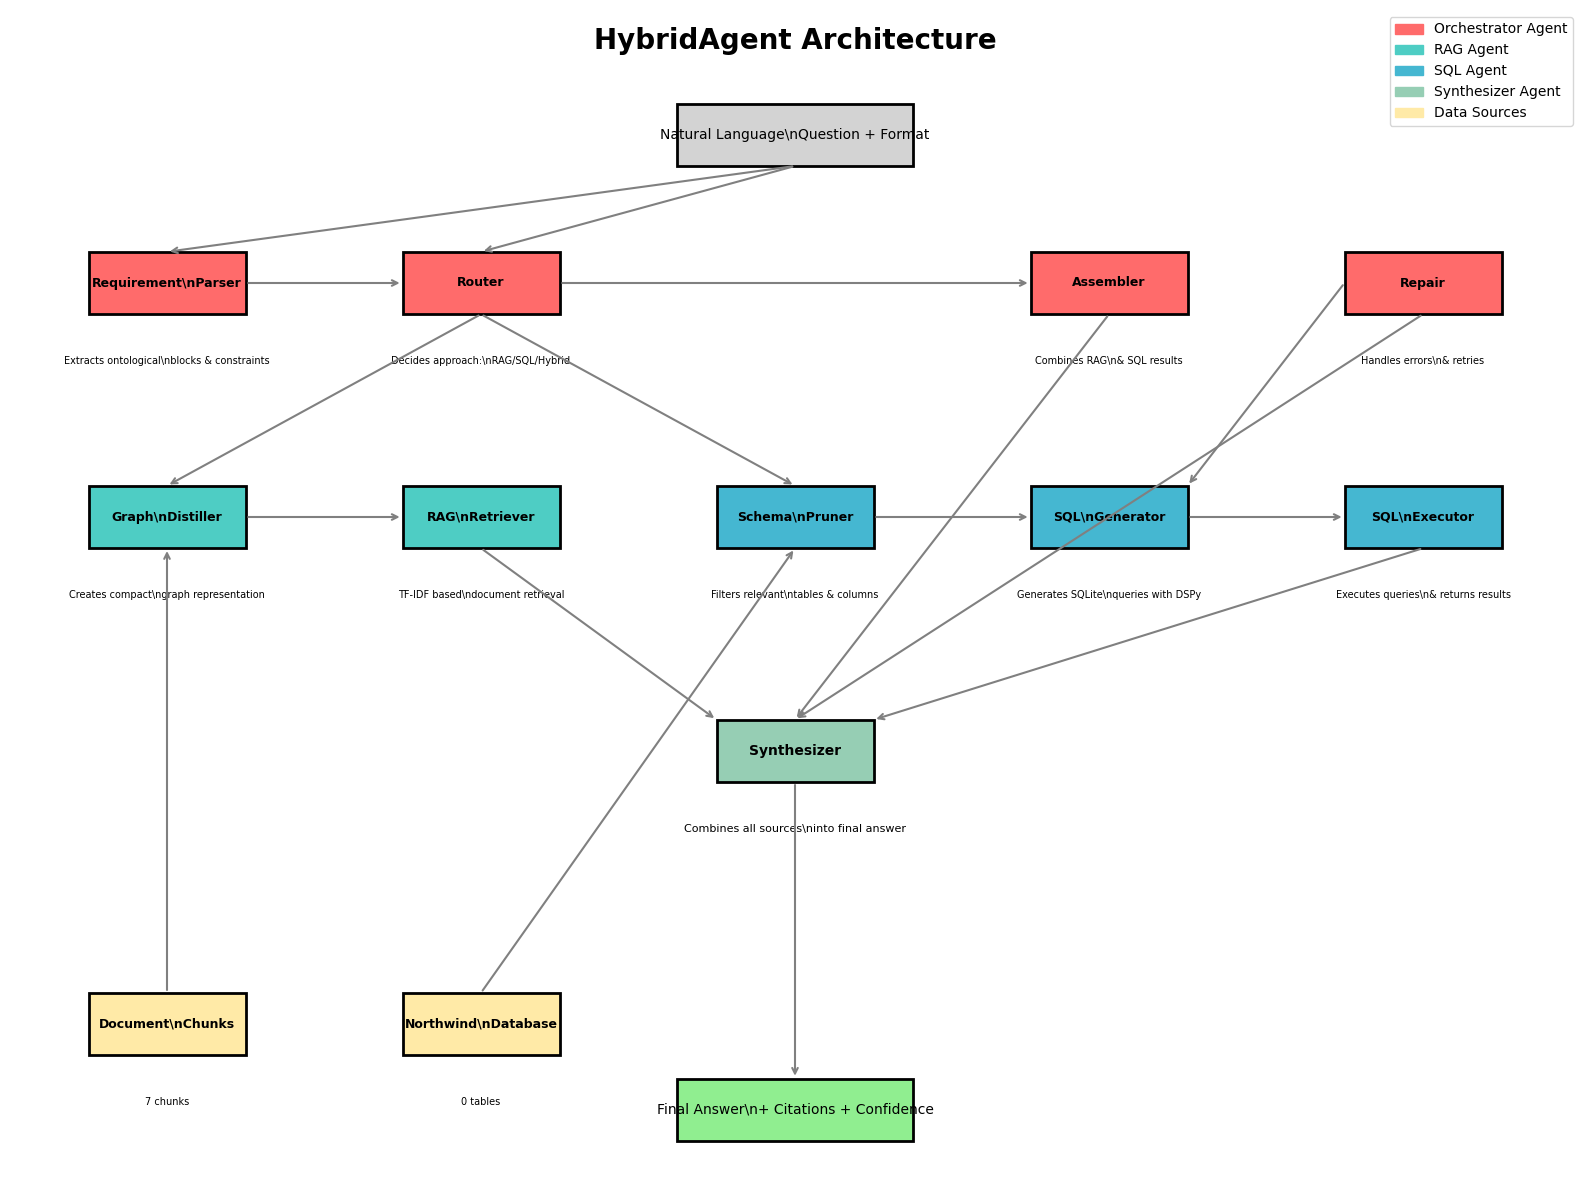

In [3]:
def create_architecture_diagram():
    """Create a comprehensive architecture diagram of the HybridAgent."""
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 12))
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 15)
    ax.axis('off')
    
    # Define colors
    colors = {
        'orchestrator': '#FF6B6B',
        'rag': '#4ECDC4', 
        'sql': '#45B7D1',
        'synthesizer': '#96CEB4',
        'data': '#FFEAA7',
        'repair': '#DDA0DD'
    }
    
    # Title
    ax.text(10, 14.5, 'HybridAgent Architecture', fontsize=20, fontweight='bold', ha='center')
    
    # Input layer
    input_box = patches.Rectangle((8.5, 13), 3, 0.8, linewidth=2, 
                                 edgecolor='black', facecolor='lightgray')
    ax.add_patch(input_box)
    ax.text(10, 13.4, 'Natural Language\\nQuestion + Format', ha='center', va='center', fontsize=10)
    
    # Orchestrator Agent components
    orchestrator_components = [
        (2, 11.5, 'Requirement\\nParser', 'Extracts ontological\\nblocks & constraints'),
        (6, 11.5, 'Router', 'Decides approach:\\nRAG/SQL/Hybrid'),
        (14, 11.5, 'Assembler', 'Combines RAG\\n& SQL results'),
        (18, 11.5, 'Repair', 'Handles errors\\n& retries')
    ]
    
    for x, y, title, desc in orchestrator_components:
        box = patches.Rectangle((x-1, y-0.4), 2, 0.8, linewidth=2,
                               edgecolor='black', facecolor=colors['orchestrator'])
        ax.add_patch(box)
        ax.text(x, y, title, ha='center', va='center', fontsize=9, fontweight='bold')
        ax.text(x, y-1, desc, ha='center', va='center', fontsize=7)
    
    # RAG Agent components
    rag_components = [
        (2, 8.5, 'Graph\\nDistiller', 'Creates compact\\ngraph representation'),
        (6, 8.5, 'RAG\\nRetriever', 'TF-IDF based\\ndocument retrieval')
    ]
    
    for x, y, title, desc in rag_components:
        box = patches.Rectangle((x-1, y-0.4), 2, 0.8, linewidth=2,
                               edgecolor='black', facecolor=colors['rag'])
        ax.add_patch(box)
        ax.text(x, y, title, ha='center', va='center', fontsize=9, fontweight='bold')
        ax.text(x, y-1, desc, ha='center', va='center', fontsize=7)
    
    # SQL Agent components
    sql_components = [
        (10, 8.5, 'Schema\\nPruner', 'Filters relevant\\ntables & columns'),
        (14, 8.5, 'SQL\\nGenerator', 'Generates SQLite\\nqueries with DSPy'),
        (18, 8.5, 'SQL\\nExecutor', 'Executes queries\\n& returns results')
    ]
    
    for x, y, title, desc in sql_components:
        box = patches.Rectangle((x-1, y-0.4), 2, 0.8, linewidth=2,
                               edgecolor='black', facecolor=colors['sql'])
        ax.add_patch(box)
        ax.text(x, y, title, ha='center', va='center', fontsize=9, fontweight='bold')
        ax.text(x, y-1, desc, ha='center', va='center', fontsize=7)
    
    # Synthesizer Agent
    synth_box = patches.Rectangle((9, 5.1), 2, 0.8, linewidth=2,
                                 edgecolor='black', facecolor=colors['synthesizer'])
    ax.add_patch(synth_box)
    ax.text(10, 5.5, 'Synthesizer', ha='center', va='center', fontsize=10, fontweight='bold')
    ax.text(10, 4.5, 'Combines all sources\\ninto final answer', ha='center', va='center', fontsize=8)
    
    # Data sources
    data_sources = [
        (2, 2, 'Document\\nChunks', f'{len(agent.rag_retriever.get_all_chunks()) if agent else "N/A"} chunks'),
        (6, 2, 'Northwind\\nDatabase', f'{len(agent.sql_inspector.schema_cache) if agent else "N/A"} tables')
    ]
    
    for x, y, title, desc in data_sources:
        box = patches.Rectangle((x-1, y-0.4), 2, 0.8, linewidth=2,
                               edgecolor='black', facecolor=colors['data'])
        ax.add_patch(box)
        ax.text(x, y, title, ha='center', va='center', fontsize=9, fontweight='bold')
        ax.text(x, y-1, desc, ha='center', va='center', fontsize=7)
    
    # Output
    output_box = patches.Rectangle((8.5, 0.5), 3, 0.8, linewidth=2,
                                  edgecolor='black', facecolor='lightgreen')
    ax.add_patch(output_box)
    ax.text(10, 0.9, 'Final Answer\\n+ Citations + Confidence', ha='center', va='center', fontsize=10)
    
    # Add arrows to show flow
    arrows = [
        # Input to orchestrator
        (10, 13, 2, 11.9),  # to requirement parser
        (10, 13, 6, 11.9),  # to router
        
        # Orchestrator flow
        (3, 11.5, 5, 11.5),  # parser to router
        (7, 11.5, 13, 11.5), # router to assembler
        
        # Router to agents
        (6, 11.1, 2, 8.9),   # to RAG distiller
        (6, 11.1, 10, 8.9),  # to SQL pruner
        
        # RAG flow
        (3, 8.5, 5, 8.5),    # distiller to retriever
        (2, 2.4, 2, 8.1),    # data to distiller
        
        # SQL flow
        (11, 8.5, 13, 8.5),  # pruner to generator
        (15, 8.5, 17, 8.5),  # generator to executor
        (6, 2.4, 10, 8.1),   # data to pruner
        
        # To synthesizer
        (6, 8.1, 9, 5.9),    # RAG to synthesizer
        (18, 8.1, 11, 5.9),  # SQL to synthesizer
        (14, 11.1, 10, 5.9), # assembler to synthesizer
        
        # To output
        (10, 5.1, 10, 1.3),  # synthesizer to output
        
        # Repair loops
        (17, 11.5, 15, 8.9), # repair to SQL generator
        (18, 11.1, 10, 5.9), # repair to synthesizer
    ]
    
    for x1, y1, x2, y2 in arrows:
        ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                   arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))
    
    # Add legend
    legend_elements = [
        patches.Patch(color=colors['orchestrator'], label='Orchestrator Agent'),
        patches.Patch(color=colors['rag'], label='RAG Agent'),
        patches.Patch(color=colors['sql'], label='SQL Agent'),
        patches.Patch(color=colors['synthesizer'], label='Synthesizer Agent'),
        patches.Patch(color=colors['data'], label='Data Sources'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()

if agent:
    create_architecture_diagram()
else:
    print("Cannot create architecture diagram without initialized agent")


## 3. LangGraph Workflow Visualization

Let's create a detailed visualization of the LangGraph workflow showing all nodes and conditional edges.


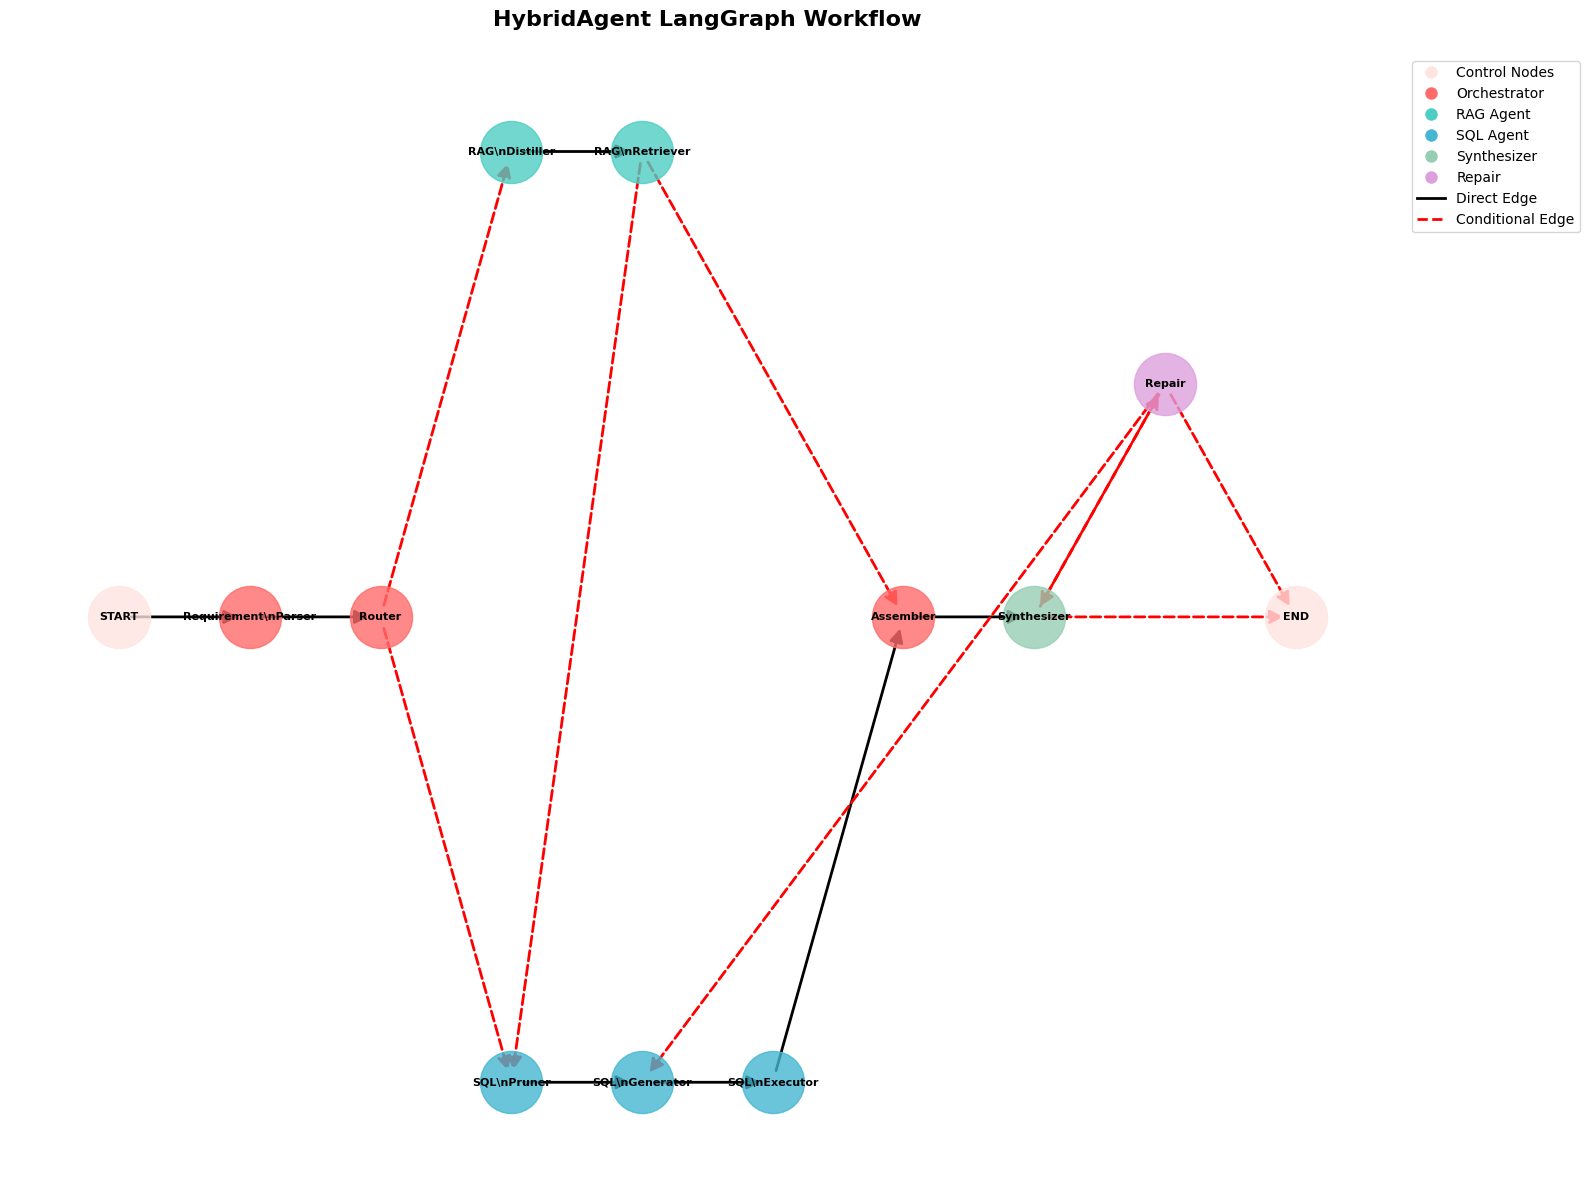


Conditional Routing Logic:

Router Node:
  - approach='rag' -> rag_distiller
  - approach='sql' -> sql_pruner
  - approach='hybrid' -> rag_distiller (then continues to SQL)

RAG Retriever Node:
  - approach='hybrid' -> sql_pruner
  - approach='rag' -> assembler

Synthesizer Node:
  - Has errors OR repair_count < max_repairs -> repair
  - Success -> END

Repair Node:
  - repair_type='sql_error' -> sql_generator
  - repair_type='invalid_output' -> synthesizer
  - max_repairs reached -> END


In [4]:
def create_langgraph_visualization():
    """Create a NetworkX visualization of the LangGraph workflow."""
    
    # Create directed graph
    G = nx.DiGraph()
    
    # Add nodes with categories
    nodes = {
        'START': {'category': 'control', 'label': 'START'},
        'requirement_parser': {'category': 'orchestrator', 'label': 'Requirement\\nParser'},
        'router': {'category': 'orchestrator', 'label': 'Router'},
        'rag_distiller': {'category': 'rag', 'label': 'RAG\\nDistiller'},
        'rag_retriever': {'category': 'rag', 'label': 'RAG\\nRetriever'},
        'sql_pruner': {'category': 'sql', 'label': 'SQL\\nPruner'},
        'sql_generator': {'category': 'sql', 'label': 'SQL\\nGenerator'},
        'sql_executor': {'category': 'sql', 'label': 'SQL\\nExecutor'},
        'assembler': {'category': 'orchestrator', 'label': 'Assembler'},
        'synthesizer': {'category': 'synthesizer', 'label': 'Synthesizer'},
        'repair': {'category': 'repair', 'label': 'Repair'},
        'END': {'category': 'control', 'label': 'END'}
    }
    
    for node_id, attrs in nodes.items():
        G.add_node(node_id, **attrs)
    
    # Add edges with types
    edges = [
        ('START', 'requirement_parser', 'direct'),
        ('requirement_parser', 'router', 'direct'),
        ('router', 'rag_distiller', 'conditional'),
        ('router', 'sql_pruner', 'conditional'),
        ('rag_distiller', 'rag_retriever', 'direct'),
        ('rag_retriever', 'sql_pruner', 'conditional'),
        ('rag_retriever', 'assembler', 'conditional'),
        ('sql_pruner', 'sql_generator', 'direct'),
        ('sql_generator', 'sql_executor', 'direct'),
        ('sql_executor', 'assembler', 'direct'),
        ('assembler', 'synthesizer', 'direct'),
        ('synthesizer', 'repair', 'conditional'),
        ('synthesizer', 'END', 'conditional'),
        ('repair', 'sql_generator', 'conditional'),
        ('repair', 'synthesizer', 'conditional'),
        ('repair', 'END', 'conditional'),
    ]
    
    for source, target, edge_type in edges:
        G.add_edge(source, target, type=edge_type)
    
    # Create layout
    plt.figure(figsize=(16, 12))
    
    # Use hierarchical layout
    pos = {
        'START': (0, 5),
        'requirement_parser': (1, 5),
        'router': (2, 5),
        'rag_distiller': (3, 7),
        'rag_retriever': (4, 7),
        'sql_pruner': (3, 3),
        'sql_generator': (4, 3),
        'sql_executor': (5, 3),
        'assembler': (6, 5),
        'synthesizer': (7, 5),
        'repair': (8, 6),
        'END': (9, 5)
    }
    
    # Define colors for different node categories
    node_colors = {
        'control': '#FFE4E1',
        'orchestrator': '#FF6B6B',
        'rag': '#4ECDC4',
        'sql': '#45B7D1',
        'synthesizer': '#96CEB4',
        'repair': '#DDA0DD'
    }
    
    # Draw nodes
    for category, color in node_colors.items():
        node_list = [n for n, d in G.nodes(data=True) if d['category'] == category]
        nx.draw_networkx_nodes(G, pos, nodelist=node_list, 
                              node_color=color, node_size=2000, alpha=0.8)
    
    # Draw edges
    direct_edges = [(u, v) for u, v, d in G.edges(data=True) if d['type'] == 'direct']
    conditional_edges = [(u, v) for u, v, d in G.edges(data=True) if d['type'] == 'conditional']
    
    nx.draw_networkx_edges(G, pos, edgelist=direct_edges, 
                          edge_color='black', arrows=True, arrowsize=20, width=2)
    nx.draw_networkx_edges(G, pos, edgelist=conditional_edges, 
                          edge_color='red', arrows=True, arrowsize=20, width=2, style='dashed')
    
    # Draw labels
    labels = {n: d['label'] for n, d in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight='bold')
    
    # Add title and legend
    plt.title('HybridAgent LangGraph Workflow', fontsize=16, fontweight='bold', pad=20)
    
    # Create custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=node_colors['control'], 
               markersize=10, label='Control Nodes'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=node_colors['orchestrator'], 
               markersize=10, label='Orchestrator'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=node_colors['rag'], 
               markersize=10, label='RAG Agent'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=node_colors['sql'], 
               markersize=10, label='SQL Agent'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=node_colors['synthesizer'], 
               markersize=10, label='Synthesizer'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=node_colors['repair'], 
               markersize=10, label='Repair'),
        Line2D([0], [0], color='black', linewidth=2, label='Direct Edge'),
        Line2D([0], [0], color='red', linewidth=2, linestyle='--', label='Conditional Edge')
    ]
    
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print routing conditions
    print("\nConditional Routing Logic:")
    print("\nRouter Node:")
    print("  - approach='rag' -> rag_distiller")
    print("  - approach='sql' -> sql_pruner")
    print("  - approach='hybrid' -> rag_distiller (then continues to SQL)")
    
    print("\nRAG Retriever Node:")
    print("  - approach='hybrid' -> sql_pruner")
    print("  - approach='rag' -> assembler")
    
    print("\nSynthesizer Node:")
    print("  - Has errors OR repair_count < max_repairs -> repair")
    print("  - Success -> END")
    
    print("\nRepair Node:")
    print("  - repair_type='sql_error' -> sql_generator")
    print("  - repair_type='invalid_output' -> synthesizer")
    print("  - max_repairs reached -> END")

if agent:
    create_langgraph_visualization()
else:
    print("Cannot create LangGraph visualization without initialized agent")


## 4. Component Deep Dive

Let's analyze the individual components and their capabilities.


RAG Component Analysis
Total document chunks: 7

SQL Component Analysis
Database tables: 0
Tables: 


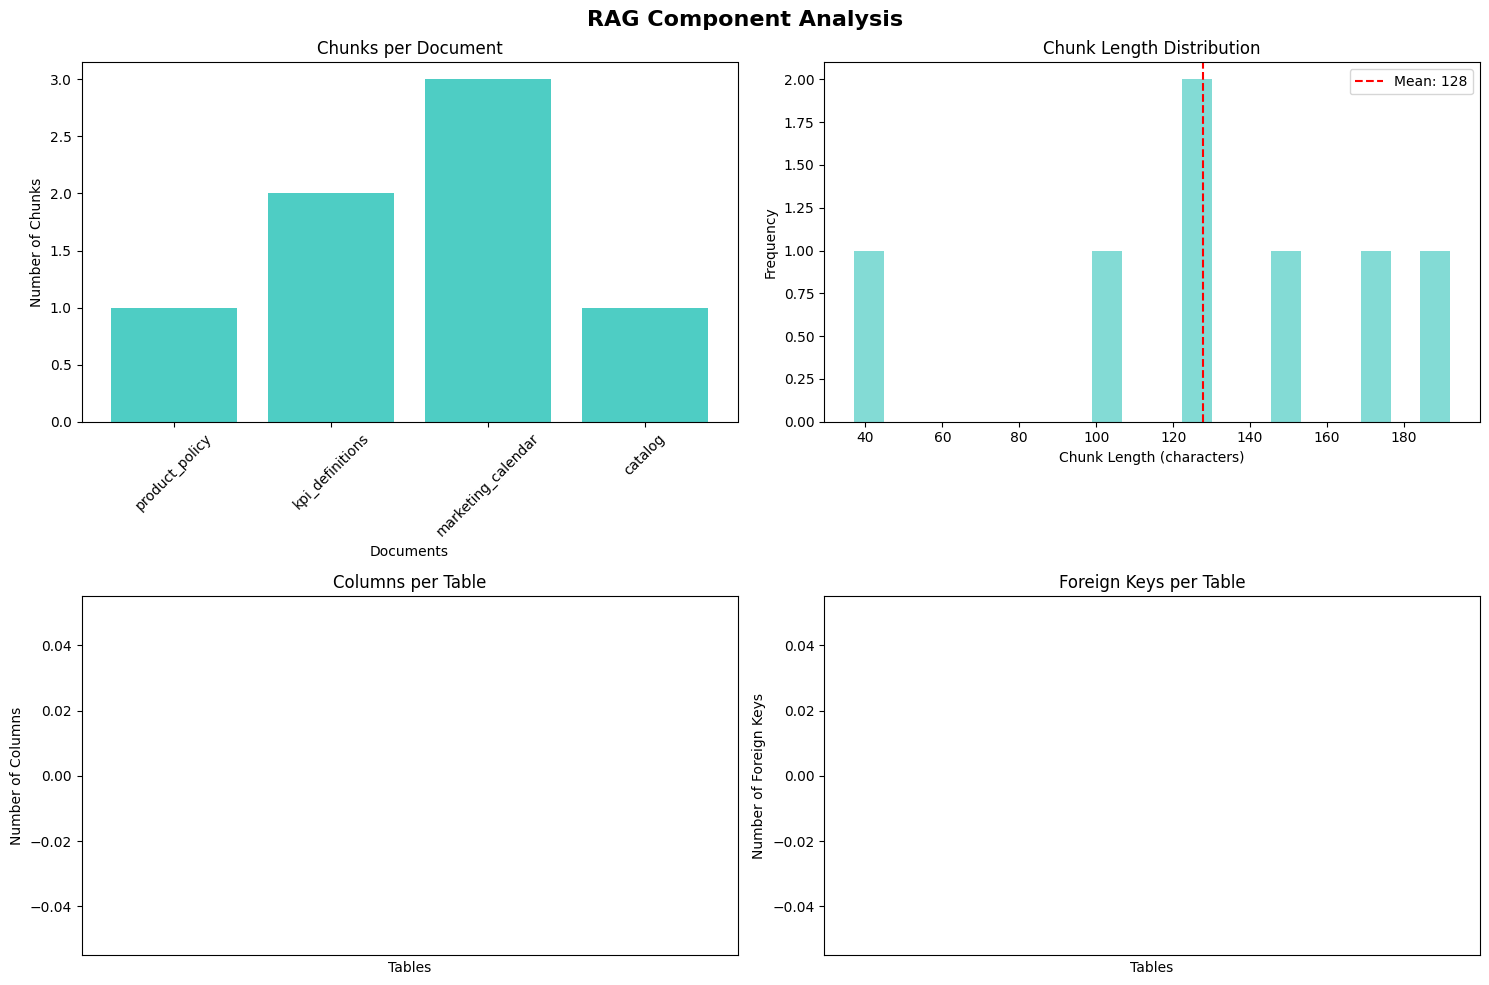


Database Schema Details:


In [5]:
def analyze_components():
    """Analyze and visualize individual agent components."""
    
    if not agent:
        print("Agent not initialized")
        return
    
    # RAG Component Analysis
    print("RAG Component Analysis")
    print("=" * 50)
    
    chunks = agent.rag_retriever.get_all_chunks()
    print(f"Total document chunks: {len(chunks)}")
    
    # Analyze chunks by source
    chunk_by_source = {}
    chunk_lengths = []
    
    for chunk in chunks:
        source = chunk.source
        if source not in chunk_by_source:
            chunk_by_source[source] = 0
        chunk_by_source[source] += 1
        chunk_lengths.append(len(chunk.content))
    
    # Create subplot for RAG analysis
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('RAG Component Analysis', fontsize=16, fontweight='bold')
    
    # Chunks per document
    sources = list(chunk_by_source.keys())
    counts = list(chunk_by_source.values())
    ax1.bar(range(len(sources)), counts, color='#4ECDC4')
    ax1.set_xlabel('Documents')
    ax1.set_ylabel('Number of Chunks')
    ax1.set_title('Chunks per Document')
    ax1.set_xticks(range(len(sources)))
    ax1.set_xticklabels([s.replace('.md', '') for s in sources], rotation=45)
    
    # Chunk length distribution
    ax2.hist(chunk_lengths, bins=20, color='#4ECDC4', alpha=0.7)
    ax2.set_xlabel('Chunk Length (characters)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Chunk Length Distribution')
    ax2.axvline(np.mean(chunk_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(chunk_lengths):.0f}')
    ax2.legend()
    
    # SQL Component Analysis
    print(f"\nSQL Component Analysis")
    print("=" * 50)
    
    tables = list(agent.sql_inspector.schema_cache.keys())
    print(f"Database tables: {len(tables)}")
    print(f"Tables: {', '.join(tables)}")
    
    # Analyze table structures
    table_column_counts = []
    table_fk_counts = []
    
    for table_name, table_info in agent.sql_inspector.schema_cache.items():
        table_column_counts.append(len(table_info.columns))
        table_fk_counts.append(len(table_info.foreign_keys))
    
    # Table column counts
    ax3.bar(range(len(tables)), table_column_counts, color='#45B7D1')
    ax3.set_xlabel('Tables')
    ax3.set_ylabel('Number of Columns')
    ax3.set_title('Columns per Table')
    ax3.set_xticks(range(len(tables)))
    ax3.set_xticklabels(tables, rotation=45)
    
    # Foreign key relationships
    ax4.bar(range(len(tables)), table_fk_counts, color='#45B7D1')
    ax4.set_xlabel('Tables')
    ax4.set_ylabel('Number of Foreign Keys')
    ax4.set_title('Foreign Keys per Table')
    ax4.set_xticks(range(len(tables)))
    ax4.set_xticklabels(tables, rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed schema info
    print(f"\nDatabase Schema Details:")
    for table_name, table_info in agent.sql_inspector.schema_cache.items():
        print(f"\n  {table_name}:")
        print(f"    - Columns: {len(table_info.columns)}")
        print(f"    - Primary Keys: {table_info.primary_keys}")
        print(f"    - Foreign Keys: {len(table_info.foreign_keys)}")
        if table_info.foreign_keys:
            for fk in table_info.foreign_keys:
                print(f"      - {fk['column']} -> {fk['references_table']}.{fk['references_column']}")

analyze_components()
